In [1]:
from fastai.vision import *
from fastai.basics import *
from fastai.utils.mem import *
from fastai.callbacks import *

In [2]:
import os

## Download data

In [4]:
download_url = "http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz"
filename = "food-101.tar.gz"
cur_dir = os.getcwd()
data_path = cur_dir + '/data' + '/' + filename
dest = Path(data_path)
dest

PosixPath('/home/jupyter/tutorials/fastai/course-v3/nbs/dl1/Projects/data/food-101.tar.gz')

Only run the first time through to download the tar file

In [ ]:
download_data(download_url,filename,ext='')

In [5]:
path = Path(cur_dir + '/' + 'data'  + '/' + 'food-101' + '/' + 'food-101')
path = Path(cur_dir,'data','food-101','food-101')
path

PosixPath('/home/jupyter/tutorials/fastai/course-v3/nbs/dl1/Projects/data/food-101/food-101')

In [6]:
def get_valid_files(fpath):
    with open(fpath, 'r') as f:
        line_list = f.read().splitlines()
        file_list = [i.split('/')[1] + '.jpg' for i in line_list]
    return file_list


In [7]:
def get_data(label_list, transforms, size, bs):
    return (label_list.transform(transforms, size=size)
           .databunch(bs=bs).normalize(imagenet_stats))

Use a set of transforms to randomly modify the training data to avoid overfitting by providing regularization essentially increasing the size of the dataset without having to gather more data. The transforms used are important and have to be tailored to the problem. For this classification problem the default fastai values work well but they can be experimented with and should be treated as hyperparameters. I increased the zoom because the texture of the food seems pretty important.

In [9]:
file_list = get_valid_files(Path(path, 'meta','test.txt'))
tfms = get_transforms(max_zoom=1.2)
tfms

([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmPixel (flip_lr), kwargs={}, p=0.5, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-10.0, 10.0)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.0, 1.2), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.4, 0.6)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.8, 1.25)}, p=0.75, resolved={}, do

In [10]:
image_list = ImageList.from_folder(Path(path, 'images'))
image_list = image_list.split_by_files(file_list)
label_list = image_list.label_from_folder()

Start with a smaller size image so that it trains faster and then we will use the full resolution image to finish training

In [11]:
data = get_data(label_list, tfms, 256, 64)

Visualize the transforms for some images to make sure they make sense for the dataset

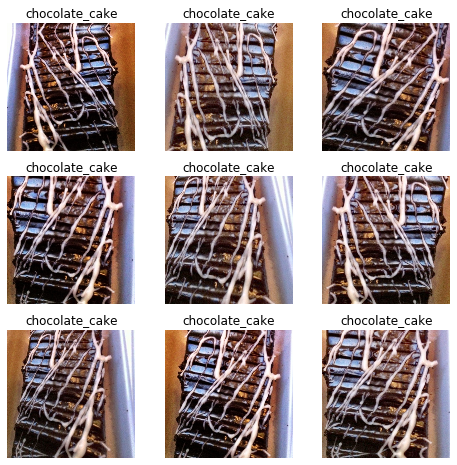

In [12]:
def _plot(i,j,ax):
    x,y = data.train_ds[3]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,8))

In [11]:
def do_fit(learn, lr, epochs, save_name):
    for i in range(epochs):
        learn.fit_one_cycle(1,lr)
        learn.save(save_name)

Create the learner object with a resnet34 model with pretrained weights from imagenet. Using transfer learning can greatly speed up the process because the model already has learned specific features of images and now we can just fine tune the parameters to this specific dataset.

In [61]:
gc.collect()
learn = cnn_learner(data, models.resnet34, metrics=accuracy, bn_final=True)

Use the learning rate finder to run the training for a number of batches to see what learning rates best reduce the loss

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

Start by just training the last layers that do the classification. The previous layers' weights are frozen at the pre-trained values.

In [ ]:
learn.fit_one_cycle(2, max_lr=1e-1)

Once the accuracy stops increasing unfreeze the previous layers and continue training the whole model with differential learning rates.

In [70]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(3,max_lr=slice(1e-5,1e-2))

In [26]:
learn.save('res34-256')

Get the full resolution images and load the saved weights

In [12]:
learn = None
data = get_data(label_list, tfms, 512, 32)
gc.collect()
learn = cnn_learner(data, models.resnet34, metrics=error_rate, bn_final=True).load('res34-256').to_fp16()

In [13]:
learn.data.train_ds
torch.cuda.empty_cache()
free = gpu_mem_get_free_no_cache()
free

7058

In [22]:
preds = learn.get_preds()

In [36]:
accuracy(preds[0], preds[1])

tensor(0.7191)

Plot some of the images with the highest loss to see what sort of images the model is failing to classify. From this, we can see that some of the images look like they are labeled incorrectly and the model is actually getting the correct answer. Another type of image that the model struggles with are ones that contain multiple foods and the model ends up focusing on the incorrect one. 

The first problem is a problem with the labeling of the data and this could be helped by going through the data that is incorrectly labeled and fixing it or throwing it out. The second problem is harder to fix but there are a couple of approaches we could take. One idea is to try to use transforms when running the predictions on the test set and averaging the predictions. This could help if some of the transforms favor the correct answer over the incorrect answer. Another possibility is to change the softmax to a binary classification and look at the top output values. 

In [37]:
interp = ClassificationInterpretation.from_learner(learn)

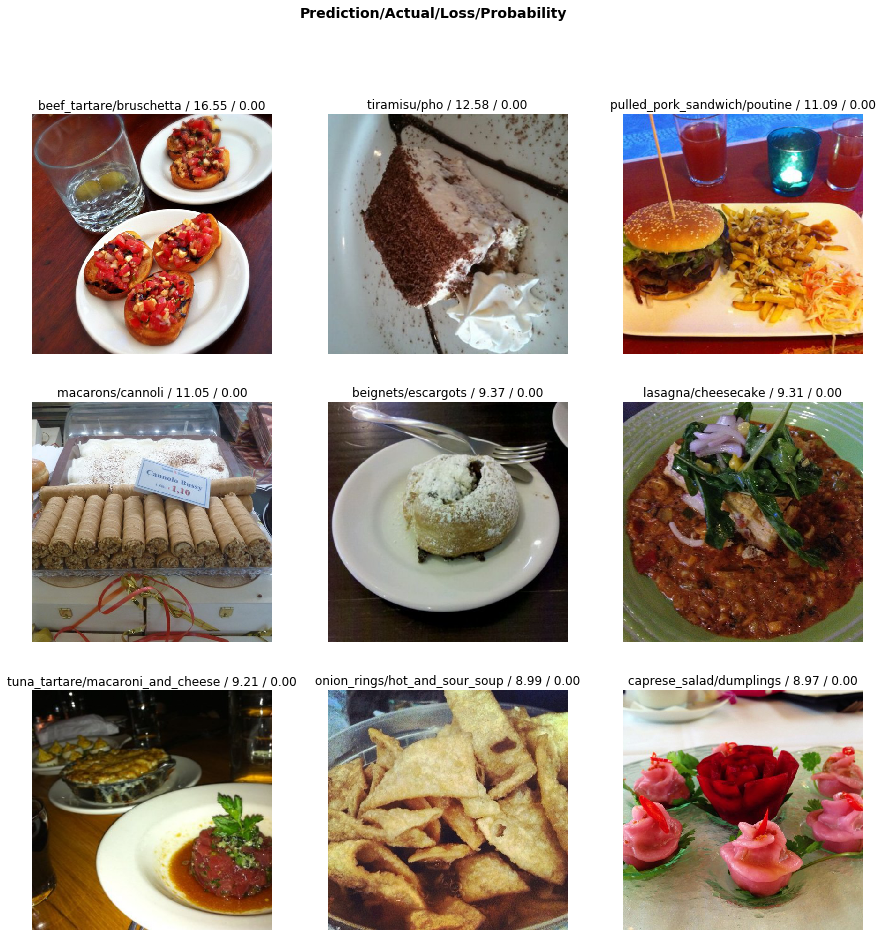

In [40]:
interp.plot_top_losses(9,figsize=(15,15))

### Training learner on full image size

In [ ]:
learn.lr_find()

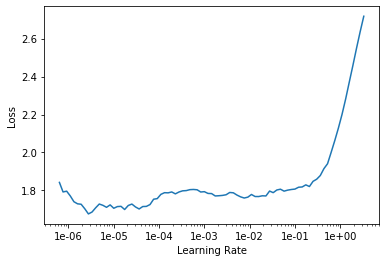

In [20]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(1, max_lr=1e-1)

In [21]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(3, max_lr=slice(1e-5,1e-2))

In [23]:
learn.save('res34-large')

Use test time augmentation to help predict on the test set

In [25]:
ypred, ys = learn.TTA()

In [26]:
accuracy(ypred,ys)

tensor(0.7277)

### Using Resnet50 architechture

In [ ]:
learn = None
learn50 = None
gc.collect()
# Using size 224 images
data = get_data(label_list, tfms, 224, 32)
learn50 = cnn_learner(data, models.resnet50, metrics=accuracy, bn_final=True).load('res50-224').to_fp16()

In [25]:
# Will stop training when accuracy stops increasing
cb=SaveModelCallback(learn50,monitor='accuracy', name='res50-224')

In [49]:
learn50.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.10E-02
Min loss divided by 10: 1.74E-02


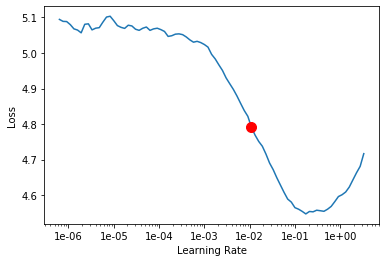

In [52]:
learn50.recorder.plot(suggestion=True)

In [54]:
min_grad_lr = learn50.recorder.min_grad_lr
min_grad_lr

0.01096478196143185

In [ ]:
learn50.fit_one_cycle(3, max_lr=min_grad_lr)

In [58]:
learn50.save('res50-224')

In [12]:
learn50.unfreeze()

In [60]:
learn50.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


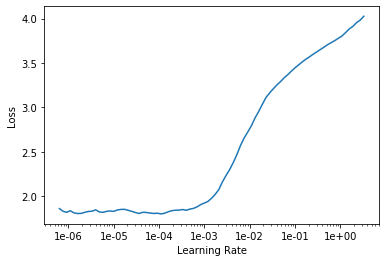

In [61]:
learn50.recorder.plot()

In [13]:
learn50.fit_one_cycle(3, slice(1e-5,1e-3), callbacks=[cb])

epoch,train_loss,valid_loss,accuracy,time
0,1.500351,0.905727,0.761941,16:14
1,1.492407,0.822062,0.780832,15:35
2,1.338647,0.802185,0.788198,15:35


Better model found at epoch 0 with accuracy value: 0.761940598487854.
Better model found at epoch 1 with accuracy value: 0.7808316946029663.
Better model found at epoch 2 with accuracy value: 0.7881979942321777.


In [14]:
learn50.save('res50-224')

In [13]:
learn50 = None
gc.collect()
# Use full image size
data = get_data(label_list, tfms, 512, 24)
learn50 = cnn_learner(data, models.resnet50, metrics=[accuracy,top_k_accuracy], bn_final=True).load('res50-224').to_fp16()

In [11]:
learn50.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


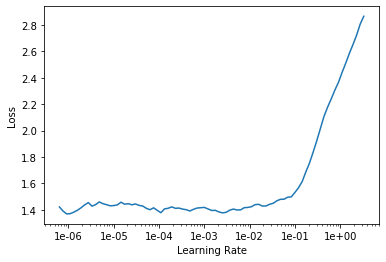

In [12]:
learn50.recorder.plot()

In [26]:
learn50.fit_one_cycle(3, slice(1e-5,1e-3), callbacks=[cb])

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.760454,1.140651,0.705545,0.909307,47:31
1,1.700637,1.013188,0.736158,0.924238,47:27
2,1.657344,0.996874,0.739802,0.926891,47:25


Better model found at epoch 0 with accuracy value: 0.7055445313453674.
Better model found at epoch 1 with accuracy value: 0.7361584305763245.
Better model found at epoch 2 with accuracy value: 0.7398020029067993.


In [10]:
learn50.unfreeze()

In [15]:
learn50.fit_one_cycle(2, slice(1e-6,1e-4), callbacks=[cb])

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.619412,0.901685,0.762059,0.938891,1:05:09
1,1.555540,0.876923,0.771248,0.941703,1:05:05


Better model found at epoch 0 with accuracy value: 0.7620593905448914.
Better model found at epoch 1 with accuracy value: 0.7712475061416626.


In [14]:
learn50.fit_one_cycle(1, slice(1e-6,1e-3), callbacks=[cb])

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.337377,0.737197,0.802851,0.954653,47:17


Better model found at epoch 0 with accuracy value: 0.8028514981269836.


In [14]:
preds, ys = learn50.TTA()

In [16]:
accuracy(preds,ys)

tensor(0.8052)